In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR

In [101]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [102]:
print(train.shape)
print(test.shape)

(8523, 12)
(5681, 11)


In [103]:
print(train.describe(include= 'all'))

       Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
count             8523  7060.000000             8523      8523.000000   
unique            1559          NaN                5              NaN   
top              FDG33          NaN          Low Fat              NaN   
freq                10          NaN             5089              NaN   
mean               NaN    12.857645              NaN         0.066132   
std                NaN     4.643456              NaN         0.051598   
min                NaN     4.555000              NaN         0.000000   
25%                NaN     8.773750              NaN         0.026989   
50%                NaN    12.600000              NaN         0.053931   
75%                NaN    16.850000              NaN         0.094585   
max                NaN    21.350000              NaN         0.328391   

                    Item_Type     Item_MRP Outlet_Identifier  \
count                    8523  8523.000000              852

In [104]:
print(train.head(5))

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

In [105]:
for column in train.columns:
    if(column =='Item_Identifier'):
        continue;
    if(train[column].dtype == 'str' or train[column].dtype == 'object'):
          print (train.groupby(column).size())
          print ("\n---------------------------\n")  

Item_Fat_Content
LF          316
Low Fat    5089
Regular    2889
low fat     112
reg         117
dtype: int64

---------------------------

Item_Type
Baking Goods              648
Breads                    251
Breakfast                 110
Canned                    649
Dairy                     682
Frozen Foods              856
Fruits and Vegetables    1232
Hard Drinks               214
Health and Hygiene        520
Household                 910
Meat                      425
Others                    169
Seafood                    64
Snack Foods              1200
Soft Drinks               445
Starchy Foods             148
dtype: int64

---------------------------

Outlet_Identifier
OUT010    555
OUT013    932
OUT017    926
OUT018    928
OUT019    528
OUT027    935
OUT035    930
OUT045    929
OUT046    930
OUT049    930
dtype: int64

---------------------------

Outlet_Size
High       932
Medium    2793
Small     2388
dtype: int64

---------------------------

Outlet_Location_Type
Tier 

[]

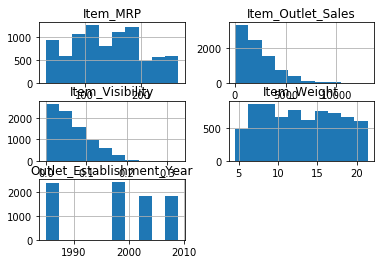

In [106]:
train.hist()
plt.plot()

# Preprocessing

## 1- Mean imputations

In [107]:
train['Item_Weight'].fillna((train['Item_Weight'].mean()), inplace = True)
test['Item_Weight'].fillna((test['Item_Weight'].mean()), inplace = True)

#train['Item_Weight'] = train.groupby('Item_Identifier').transform(lambda x: x.fillna(x.mean()))
#test['Item_Weight'] = test.groupby('Item_Identifier').transform(lambda x: x.fillna(x.mean()))

## 2- Reducing Fat content to only two category

In [108]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['low fat', 'LF'],['Low Fat','Low Fat'])
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace(['reg'], ['Regular'])

test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['low fat', 'LF'],['Low Fat','Low Fat'])
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace(['reg'], ['Regular'])

In [109]:
print (train.groupby('Item_Fat_Content').size())

Item_Fat_Content
Low Fat    5517
Regular    3006
dtype: int64


## 3- Filling mising outlet size to small 

In [110]:
train['Outlet_Size'].fillna('Small', inplace=True)
test['Outlet_Size'].fillna('Small', inplace=True)

In [111]:
print (train.groupby('Outlet_Size').size())

Outlet_Size
High       932
Medium    2793
Small     4798
dtype: int64


In [112]:
train['Item_Type'].fillna('Others', inplace=True)
test['Item_Type'].fillna('Others', inplace=True)

## 4- Establishment Year Alignment

In [113]:
train['Outlet_Establishment_Year'] = 2013 - train['Outlet_Establishment_Year']
test['Outlet_Establishment_Year'] = 2013 - test['Outlet_Establishment_Year']

## 5- Scaling Area feature to unit feature

In [114]:
train['Item_Visibility'] = np.sqrt(train['Item_Visibility'])
test['Item_Visibility'] = np.sqrt(test['Item_Visibility'])

## 6- Encoding Labels

In [115]:
columns =['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier']

sol_columns = ['Item_Identifier','Outlet_Identifier']
solution = pd.DataFrame(data=test, columns = sol_columns)
lableEncoder = LabelEncoder()

for column in columns:
    lableEncoder.fit(train[column])
    
    train[column] = lableEncoder.transform(train[column].astype('str'))
    train[column] = train[column].astype('object')
    
    test[column] = lableEncoder.transform(test[column].astype('str'))
    test[column] = test[column].astype('object')

In [84]:
target = train['Item_Outlet_Sales'] 
tpot_train = train.drop(['Item_Identifier','Item_Outlet_Sales'], axis=1)
tpot_test = test.drop(['Item_Identifier'], axis=1)
print(tpot_test.shape)
print(tpot_train.shape)


(5681, 10)
(8523, 10)


In [85]:
columnsToNormalize = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
normalizer = Normalizer()
normalizer.fit(tpot_train[columnsToNormalize])

tpot_train[columnsToNormalize] = normalizer.transform(tpot_train[columnsToNormalize])
tpot_test[columnsToNormalize] = normalizer.transform(tpot_test[columnsToNormalize])

In [126]:
from tpot import TPOTRegressor
X_train, X_test, y_train, y_test = train_test_split(tpot_train, target, train_size = 0.90, test_size = 0.001)

In [ ]:
clf = GridSearchCV(SVR(), cv=5,
                   param_grid={"kernel" : ['rbf', 'linear'],
                               "C": [1e2, 1e3, 1e4, 1e5],
                               "gamma": np.logspace(1, 2, 3, 4)})
clf.fit(X_train, y_train)

In [123]:
y_pred = clf.best_estimator_.predict(X_test)
print(mean_squared_error(y_test, y_pred))

1626653.86056


## Printing final prediction to csv file

In [124]:
solution['Item_Outlet_Sales'] = clf.best_estimator_.predict(tpot_test)
solution.to_csv('svr.csv', index=False)

In [125]:
print(clf.best_estimator_)

SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=10.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
